<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/cwiczenia_4a_regression_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.



In [1]:

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt



**1-dimensional data**

In [2]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 100
low=0
high=12
error=10

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(100,) (100,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


<function matplotlib.pyplot.show>

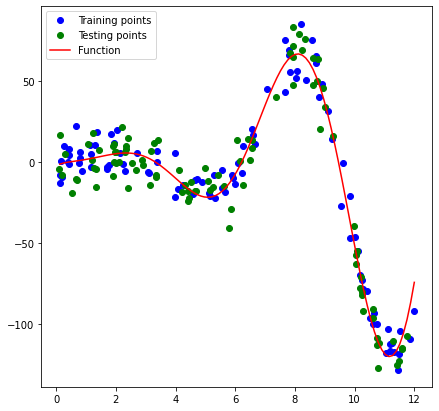

In [3]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show


**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [4]:
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

XX_test_n = XX_test - mean
XX_test_n /= std

meany = yy_train.mean(axis=0)
yy_train_n = yy_train - meany
stdy = yy_train_n.std(axis=0)
yy_train_n /= stdy

yy_test_n = yy_test - meany
yy_test_n /= stdy



#XX_train_n = XX_train_n.reshape((len(XX_train_n),1))
#XX_test_n  = XX_test_n.reshape((len(XX_test_n),1))


In [5]:
! pip install optuna

import optuna

Define objective

In [6]:
def objective(trial):


    units = int(trial.suggest_discrete_uniform("units1", 32,1024,1))
    dropout = trial.suggest_uniform('dropout1', .00,.50)
    act = trial.suggest_categorical('activation', ['relu','sigmoid','linear'])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    #epochs = int(trial.suggest_discrete_uniform('epochs', 10,100,1))
    epochs = 400

    model0 = Sequential(name='network')
    model0.add(Dense(units, input_shape = (1,), activation = act))
    model0.add(Dropout(dropout))
    model0.add(Dense(units, input_shape = (1,), activation = act))
    model0.add(Dropout(dropout))
    model0.add(Dense(1,activation='linear'))

    #sgd0 = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer

    #  early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    model0.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
    history = model0.fit(XX_train_n, yy_train_n, batch_size = 128, epochs = epochs, validation_data=(XX_test_n, yy_test_n), verbose = 0 , callbacks=[es])


    # Evaluate the model accuracy on the validation set.
    score = model0.evaluate(XX_test_n, yy_test_n, verbose=0)
    return score[1]

# Find the best parameters

In [7]:


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)


[I 2020-12-07 19:43:59,386] A new study created in memory with name: no-name-197ac239-f045-438b-985c-7a9e2a4e443b
[I 2020-12-07 19:44:06,965] Trial 0 finished with value: 0.9588575959205627 and parameters: {'units1': 303.0, 'dropout1': 0.4690182062086697, 'activation': 'sigmoid', 'lr': 2.7867822470910794e-05}. Best is trial 0 with value: 0.9588575959205627.
[I 2020-12-07 19:44:13,334] Trial 1 finished with value: 0.7835148572921753 and parameters: {'units1': 665.0, 'dropout1': 0.129143717401001, 'activation': 'sigmoid', 'lr': 0.0018053175196004409}. Best is trial 1 with value: 0.7835148572921753.
[I 2020-12-07 19:44:15,134] Trial 2 finished with value: 0.8034593462944031 and parameters: {'units1': 546.0, 'dropout1': 0.4195954938789724, 'activation': 'linear', 'lr': 1.7021073808461897e-05}. Best is trial 1 with value: 0.7835148572921753.


Epoch 00092: early stopping


[I 2020-12-07 19:44:18,652] Trial 3 finished with value: 0.05503837764263153 and parameters: {'units1': 331.0, 'dropout1': 0.33257945729979466, 'activation': 'relu', 'lr': 0.012256683530499884}. Best is trial 3 with value: 0.05503837764263153.


Epoch 00209: early stopping


[I 2020-12-07 19:44:20,374] Trial 4 finished with value: 0.8034422397613525 and parameters: {'units1': 269.0, 'dropout1': 0.018636820294474943, 'activation': 'linear', 'lr': 7.68305979035365e-05}. Best is trial 3 with value: 0.05503837764263153.


Epoch 00085: early stopping


[I 2020-12-07 19:44:26,879] Trial 5 finished with value: 0.5224776268005371 and parameters: {'units1': 464.0, 'dropout1': 0.3381472044512047, 'activation': 'sigmoid', 'lr': 0.0032911388626245116}. Best is trial 3 with value: 0.05503837764263153.
[I 2020-12-07 19:44:33,220] Trial 6 finished with value: 0.16128690540790558 and parameters: {'units1': 354.0, 'dropout1': 0.34584238271812007, 'activation': 'relu', 'lr': 9.960150880672478e-05}. Best is trial 3 with value: 0.05503837764263153.
[I 2020-12-07 19:44:39,613] Trial 7 finished with value: 0.854601263999939 and parameters: {'units1': 762.0, 'dropout1': 0.426980941523909, 'activation': 'sigmoid', 'lr': 0.00014750730609360083}. Best is trial 3 with value: 0.05503837764263153.
[I 2020-12-07 19:44:46,055] Trial 8 finished with value: 0.05466305837035179 and parameters: {'units1': 694.0, 'dropout1': 0.43965427332858287, 'activation': 'relu', 'lr': 0.00045566011395524713}. Best is trial 8 with value: 0.05466305837035179.
[I 2020-12-07 19:4

Epoch 00074: early stopping


[I 2020-12-07 19:44:51,099] Trial 10 finished with value: 0.2716199457645416 and parameters: {'units1': 999.0, 'dropout1': 0.1972286551163346, 'activation': 'relu', 'lr': 0.08289524299345241}. Best is trial 8 with value: 0.05466305837035179.


Epoch 00197: early stopping


[I 2020-12-07 19:44:54,945] Trial 11 finished with value: 0.12898258864879608 and parameters: {'units1': 75.0, 'dropout1': 0.30703974911228316, 'activation': 'relu', 'lr': 0.04736640550213452}. Best is trial 8 with value: 0.05466305837035179.


Epoch 00226: early stopping


[I 2020-12-07 19:44:59,233] Trial 12 finished with value: 0.07120025157928467 and parameters: {'units1': 889.0, 'dropout1': 0.49877893158933995, 'activation': 'relu', 'lr': 0.01185650623572199}. Best is trial 8 with value: 0.05466305837035179.


Epoch 00260: early stopping


[I 2020-12-07 19:45:05,535] Trial 13 finished with value: 0.1499534547328949 and parameters: {'units1': 49.0, 'dropout1': 0.28054538303957627, 'activation': 'relu', 'lr': 0.0004615801799913714}. Best is trial 8 with value: 0.05466305837035179.
[I 2020-12-07 19:45:08,848] Trial 14 finished with value: 0.06632013618946075 and parameters: {'units1': 727.0, 'dropout1': 0.39995989417986344, 'activation': 'relu', 'lr': 0.013507735409079314}. Best is trial 8 with value: 0.05466305837035179.


Epoch 00192: early stopping


[I 2020-12-07 19:45:15,180] Trial 15 finished with value: 0.06422390788793564 and parameters: {'units1': 198.0, 'dropout1': 0.21852743547878448, 'activation': 'relu', 'lr': 0.0005069721191882021}. Best is trial 8 with value: 0.05466305837035179.
[I 2020-12-07 19:45:19,027] Trial 16 finished with value: 0.05567827820777893 and parameters: {'units1': 421.0, 'dropout1': 0.36821834340824044, 'activation': 'relu', 'lr': 0.009795637057152315}. Best is trial 8 with value: 0.05466305837035179.


Epoch 00212: early stopping


[I 2020-12-07 19:45:25,420] Trial 17 finished with value: 0.059125304222106934 and parameters: {'units1': 621.0, 'dropout1': 0.4505465090320467, 'activation': 'relu', 'lr': 0.00043867178189784575}. Best is trial 8 with value: 0.05466305837035179.
[I 2020-12-07 19:45:30,954] Trial 18 finished with value: 0.054031845182180405 and parameters: {'units1': 868.0, 'dropout1': 0.2700998152731374, 'activation': 'relu', 'lr': 0.035914083479756075}. Best is trial 18 with value: 0.054031845182180405.


Epoch 00343: early stopping


[I 2020-12-07 19:45:37,431] Trial 19 finished with value: 0.04743953049182892 and parameters: {'units1': 837.0, 'dropout1': 0.013776909204777754, 'activation': 'relu', 'lr': 0.0009929439775438972}. Best is trial 19 with value: 0.04743953049182892.
[I 2020-12-07 19:45:41,239] Trial 20 finished with value: 0.8296704888343811 and parameters: {'units1': 1015.0, 'dropout1': 0.04469086345430695, 'activation': 'linear', 'lr': 0.03924214266024019}. Best is trial 19 with value: 0.04743953049182892.


Epoch 00221: early stopping


[I 2020-12-07 19:45:47,679] Trial 21 finished with value: 0.05126531422138214 and parameters: {'units1': 853.0, 'dropout1': 0.14353963055641908, 'activation': 'relu', 'lr': 0.0009621654869565168}. Best is trial 19 with value: 0.04743953049182892.
[I 2020-12-07 19:45:53,754] Trial 22 finished with value: 0.04877140000462532 and parameters: {'units1': 814.0, 'dropout1': 0.13874557352601463, 'activation': 'relu', 'lr': 0.00091000433145596}. Best is trial 19 with value: 0.04743953049182892.


Epoch 00376: early stopping


[I 2020-12-07 19:45:59,985] Trial 23 finished with value: 0.0456770658493042 and parameters: {'units1': 841.0, 'dropout1': 0.08711788440559284, 'activation': 'relu', 'lr': 0.0012240020578106734}. Best is trial 23 with value: 0.0456770658493042.


Epoch 00383: early stopping


[I 2020-12-07 19:46:06,429] Trial 24 finished with value: 0.044782064855098724 and parameters: {'units1': 952.0, 'dropout1': 0.07393355714611187, 'activation': 'relu', 'lr': 0.0012620372872617536}. Best is trial 24 with value: 0.044782064855098724.
[I 2020-12-07 19:46:09,682] Trial 25 finished with value: 0.048948146402835846 and parameters: {'units1': 939.0, 'dropout1': 0.07343641218876197, 'activation': 'relu', 'lr': 0.0035965848769126826}. Best is trial 24 with value: 0.044782064855098724.


Epoch 00187: early stopping


[I 2020-12-07 19:46:14,736] Trial 26 finished with value: 0.044384635984897614 and parameters: {'units1': 1019.0, 'dropout1': 0.008231392997837081, 'activation': 'relu', 'lr': 0.0015441839161453004}. Best is trial 26 with value: 0.044384635984897614.


Epoch 00308: early stopping


[I 2020-12-07 19:46:18,880] Trial 27 finished with value: 0.09056060761213303 and parameters: {'units1': 962.0, 'dropout1': 0.07330756538531016, 'activation': 'relu', 'lr': 0.0001950493423986595}. Best is trial 26 with value: 0.044384635984897614.


Epoch 00251: early stopping


[I 2020-12-07 19:46:22,033] Trial 28 finished with value: 0.045167967677116394 and parameters: {'units1': 1024.0, 'dropout1': 0.08482276308530626, 'activation': 'relu', 'lr': 0.005920002613562559}. Best is trial 26 with value: 0.044384635984897614.


Epoch 00162: early stopping


[I 2020-12-07 19:46:28,326] Trial 29 finished with value: 0.47545871138572693 and parameters: {'units1': 945.0, 'dropout1': 0.17349108268084013, 'activation': 'sigmoid', 'lr': 0.004085172983988506}. Best is trial 26 with value: 0.044384635984897614.
[I 2020-12-07 19:46:32,112] Trial 30 finished with value: 0.0421479307115078 and parameters: {'units1': 1003.0, 'dropout1': 0.0026724215506570975, 'activation': 'relu', 'lr': 0.006381464222999871}. Best is trial 30 with value: 0.0421479307115078.


Epoch 00229: early stopping


[I 2020-12-07 19:46:34,995] Trial 31 finished with value: 0.052367739379405975 and parameters: {'units1': 1004.0, 'dropout1': 0.003399551789292552, 'activation': 'relu', 'lr': 0.0064603884516352215}. Best is trial 30 with value: 0.0421479307115078.


Epoch 00163: early stopping


[I 2020-12-07 19:46:40,563] Trial 32 finished with value: 0.04560340568423271 and parameters: {'units1': 1019.0, 'dropout1': 0.04142981054452144, 'activation': 'relu', 'lr': 0.0017885420024093348}. Best is trial 30 with value: 0.0421479307115078.


Epoch 00345: early stopping


[I 2020-12-07 19:46:44,064] Trial 33 finished with value: 0.04514428228139877 and parameters: {'units1': 940.0, 'dropout1': 0.04857149718057516, 'activation': 'relu', 'lr': 0.005915580804207267}. Best is trial 30 with value: 0.0421479307115078.


Epoch 00203: early stopping


[I 2020-12-07 19:46:47,483] Trial 34 finished with value: 0.9811054468154907 and parameters: {'units1': 942.0, 'dropout1': 0.04136444179802659, 'activation': 'sigmoid', 'lr': 0.022965756543525426}. Best is trial 30 with value: 0.0421479307115078.


Epoch 00195: early stopping


[I 2020-12-07 19:46:49,401] Trial 35 finished with value: 0.8035207390785217 and parameters: {'units1': 776.0, 'dropout1': 0.0017783665666410765, 'activation': 'linear', 'lr': 0.0017065276923441165}. Best is trial 30 with value: 0.0421479307115078.


Epoch 00098: early stopping


[I 2020-12-07 19:46:52,991] Trial 36 finished with value: 0.04196801036596298 and parameters: {'units1': 905.0, 'dropout1': 0.1090909747805494, 'activation': 'relu', 'lr': 0.005753804356073424}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00213: early stopping


[I 2020-12-07 19:46:57,117] Trial 37 finished with value: 0.0460534393787384 and parameters: {'units1': 901.0, 'dropout1': 0.09935945542356842, 'activation': 'relu', 'lr': 0.00230432045719622}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00231: early stopping


[I 2020-12-07 19:47:03,651] Trial 38 finished with value: 0.7198213338851929 and parameters: {'units1': 631.0, 'dropout1': 0.16352478090046438, 'activation': 'relu', 'lr': 1.0821002952634553e-05}. Best is trial 36 with value: 0.04196801036596298.
[I 2020-12-07 19:47:10,752] Trial 39 finished with value: 0.11274735629558563 and parameters: {'units1': 766.0, 'dropout1': 0.02056872022918941, 'activation': 'sigmoid', 'lr': 0.020464153854248674}. Best is trial 36 with value: 0.04196801036596298.
[I 2020-12-07 19:47:15,485] Trial 40 finished with value: 0.04607992246747017 and parameters: {'units1': 980.0, 'dropout1': 0.11544197577700718, 'activation': 'relu', 'lr': 0.007386005384380837}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00247: early stopping


[I 2020-12-07 19:47:18,511] Trial 41 finished with value: 0.04294949397444725 and parameters: {'units1': 907.0, 'dropout1': 0.05907485440306469, 'activation': 'relu', 'lr': 0.004402686171040428}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00146: early stopping


[I 2020-12-07 19:47:22,536] Trial 42 finished with value: 0.043322719633579254 and parameters: {'units1': 911.0, 'dropout1': 0.06305708295601184, 'activation': 'relu', 'lr': 0.004323207086962184}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00213: early stopping


[I 2020-12-07 19:47:25,812] Trial 43 finished with value: 0.04321150481700897 and parameters: {'units1': 919.0, 'dropout1': 0.028544451686393097, 'activation': 'relu', 'lr': 0.003512730127650819}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00166: early stopping


[I 2020-12-07 19:47:28,773] Trial 44 finished with value: 0.8034715056419373 and parameters: {'units1': 906.0, 'dropout1': 0.05623979172149211, 'activation': 'linear', 'lr': 0.004354887989160981}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00152: early stopping


[I 2020-12-07 19:47:33,105] Trial 45 finished with value: 0.04455344378948212 and parameters: {'units1': 805.0, 'dropout1': 0.024374385872414316, 'activation': 'relu', 'lr': 0.002912934466865906}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00234: early stopping


[I 2020-12-07 19:47:35,860] Trial 46 finished with value: 0.05733129009604454 and parameters: {'units1': 894.0, 'dropout1': 0.10392415435027916, 'activation': 'relu', 'lr': 0.016739762402135042}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00138: early stopping


[I 2020-12-07 19:47:38,860] Trial 47 finished with value: 0.04339894279837608 and parameters: {'units1': 711.0, 'dropout1': 0.060832913845993236, 'activation': 'relu', 'lr': 0.008284955857608632}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00158: early stopping


[I 2020-12-07 19:47:42,720] Trial 48 finished with value: 0.04448715224862099 and parameters: {'units1': 745.0, 'dropout1': 0.11881534743936226, 'activation': 'relu', 'lr': 0.00480140196317997}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00208: early stopping


[I 2020-12-07 19:47:46,109] Trial 49 finished with value: 0.04201124235987663 and parameters: {'units1': 677.0, 'dropout1': 0.02961831401966985, 'activation': 'relu', 'lr': 0.010258020737003609}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00181: early stopping


[I 2020-12-07 19:47:49,395] Trial 50 finished with value: 0.9812147617340088 and parameters: {'units1': 563.0, 'dropout1': 0.22799810316325952, 'activation': 'sigmoid', 'lr': 0.02473580709851227}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00185: early stopping


[I 2020-12-07 19:47:52,426] Trial 51 finished with value: 0.05003371089696884 and parameters: {'units1': 798.0, 'dropout1': 0.02740394948471845, 'activation': 'relu', 'lr': 0.008914845615942992}. Best is trial 36 with value: 0.04196801036596298.


Epoch 00144: early stopping


[I 2020-12-07 19:47:56,048] Trial 52 finished with value: 0.040770236402750015 and parameters: {'units1': 668.0, 'dropout1': 0.0005441394597501883, 'activation': 'relu', 'lr': 0.0138510439633355}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00200: early stopping


[I 2020-12-07 19:47:58,384] Trial 53 finished with value: 0.05194374918937683 and parameters: {'units1': 665.0, 'dropout1': 0.03285977356819433, 'activation': 'relu', 'lr': 0.014745044052357409}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00119: early stopping


[I 2020-12-07 19:48:02,360] Trial 54 finished with value: 0.048897236585617065 and parameters: {'units1': 517.0, 'dropout1': 0.0052125131186987195, 'activation': 'relu', 'lr': 0.09299258005700141}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00226: early stopping


[I 2020-12-07 19:48:05,391] Trial 55 finished with value: 0.04547571763396263 and parameters: {'units1': 589.0, 'dropout1': 0.027677617025098227, 'activation': 'relu', 'lr': 0.011328950360046905}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00167: early stopping


[I 2020-12-07 19:48:11,463] Trial 56 finished with value: 0.0437372587621212 and parameters: {'units1': 443.0, 'dropout1': 0.002894545254749914, 'activation': 'relu', 'lr': 0.0023587288727574835}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00369: early stopping


[I 2020-12-07 19:48:15,444] Trial 57 finished with value: 0.8036975264549255 and parameters: {'units1': 683.0, 'dropout1': 0.08694562310465545, 'activation': 'linear', 'lr': 0.05482816208714896}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00230: early stopping


[I 2020-12-07 19:48:17,516] Trial 58 finished with value: 0.04835161566734314 and parameters: {'units1': 499.0, 'dropout1': 0.049736783138549796, 'activation': 'relu', 'lr': 0.02855947878469284}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00104: early stopping


[I 2020-12-07 19:48:20,990] Trial 59 finished with value: 0.05163837969303131 and parameters: {'units1': 380.0, 'dropout1': 0.13898760167367682, 'activation': 'relu', 'lr': 0.06341140381759677}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00197: early stopping


[I 2020-12-07 19:48:23,256] Trial 60 finished with value: 0.04874091595411301 and parameters: {'units1': 850.0, 'dropout1': 0.0007565244918345329, 'activation': 'relu', 'lr': 0.010987004670285594}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00114: early stopping


[I 2020-12-07 19:48:27,764] Trial 61 finished with value: 0.04603181406855583 and parameters: {'units1': 904.0, 'dropout1': 0.06668852496208971, 'activation': 'relu', 'lr': 0.0031200403580056092}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00262: early stopping


[I 2020-12-07 19:48:31,083] Trial 62 finished with value: 0.04636899009346962 and parameters: {'units1': 870.0, 'dropout1': 0.09305719110759413, 'activation': 'relu', 'lr': 0.005093083384652113}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00187: early stopping


[I 2020-12-07 19:48:37,882] Trial 63 finished with value: 0.04861771687865257 and parameters: {'units1': 971.0, 'dropout1': 0.06261987304579042, 'activation': 'relu', 'lr': 0.0007275614161733458}. Best is trial 52 with value: 0.040770236402750015.
[I 2020-12-07 19:48:40,535] Trial 64 finished with value: 0.04362453147768974 and parameters: {'units1': 280.0, 'dropout1': 0.020908469373005487, 'activation': 'relu', 'lr': 0.016277786759994764}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00143: early stopping


[I 2020-12-07 19:48:43,669] Trial 65 finished with value: 0.05273423716425896 and parameters: {'units1': 823.0, 'dropout1': 0.03899993730899993, 'activation': 'relu', 'lr': 0.00774815314722401}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00173: early stopping


[I 2020-12-07 19:48:48,060] Trial 66 finished with value: 0.04498066380620003 and parameters: {'units1': 633.0, 'dropout1': 0.07243030366899686, 'activation': 'relu', 'lr': 0.00338368164914639}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00256: early stopping


[I 2020-12-07 19:48:52,917] Trial 67 finished with value: 0.043010540306568146 and parameters: {'units1': 920.0, 'dropout1': 0.052338990175894835, 'activation': 'relu', 'lr': 0.002098053623161687}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00282: early stopping


[I 2020-12-07 19:48:56,658] Trial 68 finished with value: 0.04394787177443504 and parameters: {'units1': 992.0, 'dropout1': 0.019573719011244745, 'activation': 'relu', 'lr': 0.002487618326098225}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00212: early stopping


[I 2020-12-07 19:48:59,936] Trial 69 finished with value: 0.048750367015600204 and parameters: {'units1': 727.0, 'dropout1': 0.12347379384553088, 'activation': 'relu', 'lr': 0.006198255567421846}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00183: early stopping


[I 2020-12-07 19:49:06,417] Trial 70 finished with value: 0.04953937232494354 and parameters: {'units1': 873.0, 'dropout1': 0.037715990877221564, 'activation': 'relu', 'lr': 0.0006485715112112375}. Best is trial 52 with value: 0.040770236402750015.
[I 2020-12-07 19:49:09,800] Trial 71 finished with value: 0.04712409898638725 and parameters: {'units1': 920.0, 'dropout1': 0.05829210547592097, 'activation': 'relu', 'lr': 0.00388212277871205}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00192: early stopping


[I 2020-12-07 19:49:13,881] Trial 72 finished with value: 0.053449489176273346 and parameters: {'units1': 927.0, 'dropout1': 0.08093857940935908, 'activation': 'relu', 'lr': 0.010014400149643493}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00238: early stopping


[I 2020-12-07 19:49:19,406] Trial 73 finished with value: 0.05189329758286476 and parameters: {'units1': 789.0, 'dropout1': 0.10294174942712528, 'activation': 'relu', 'lr': 0.0020354729246760345}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00337: early stopping


[I 2020-12-07 19:49:24,555] Trial 74 finished with value: 0.044262275099754333 and parameters: {'units1': 986.0, 'dropout1': 0.012186558007539702, 'activation': 'relu', 'lr': 0.00130762965530952}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00310: early stopping


[I 2020-12-07 19:49:27,947] Trial 75 finished with value: 0.042370155453681946 and parameters: {'units1': 829.0, 'dropout1': 0.04940570110371422, 'activation': 'relu', 'lr': 0.004663253736901048}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00196: early stopping


[I 2020-12-07 19:49:30,599] Trial 76 finished with value: 0.05345207825303078 and parameters: {'units1': 835.0, 'dropout1': 0.05062459451728759, 'activation': 'relu', 'lr': 0.013077207680153479}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00146: early stopping


[I 2020-12-07 19:49:37,403] Trial 77 finished with value: 0.1869300901889801 and parameters: {'units1': 882.0, 'dropout1': 0.0008451433395334461, 'activation': 'relu', 'lr': 3.9487803990888096e-05}. Best is trial 52 with value: 0.040770236402750015.
[I 2020-12-07 19:49:40,205] Trial 78 finished with value: 0.8033218383789062 and parameters: {'units1': 961.0, 'dropout1': 0.16307417603770236, 'activation': 'linear', 'lr': 0.0053940149645950305}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00156: early stopping


[I 2020-12-07 19:49:46,709] Trial 79 finished with value: 0.2819331884384155 and parameters: {'units1': 654.0, 'dropout1': 0.03145020080086666, 'activation': 'sigmoid', 'lr': 0.01901664088162488}. Best is trial 52 with value: 0.040770236402750015.
[I 2020-12-07 19:49:50,265] Trial 80 finished with value: 0.04928318411111832 and parameters: {'units1': 753.0, 'dropout1': 0.013904485438412911, 'activation': 'relu', 'lr': 0.031662246558144536}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00204: early stopping


[I 2020-12-07 19:49:53,462] Trial 81 finished with value: 0.04614650830626488 and parameters: {'units1': 923.0, 'dropout1': 0.050756790276114204, 'activation': 'relu', 'lr': 0.007009324591319941}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00177: early stopping


[I 2020-12-07 19:49:57,715] Trial 82 finished with value: 0.05299069359898567 and parameters: {'units1': 848.0, 'dropout1': 0.07858246216146757, 'activation': 'relu', 'lr': 0.004122347607171639}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00245: early stopping


[I 2020-12-07 19:50:02,499] Trial 83 finished with value: 0.04582931101322174 and parameters: {'units1': 882.0, 'dropout1': 0.31508982337821095, 'activation': 'relu', 'lr': 0.0028899959200443083}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00287: early stopping


[I 2020-12-07 19:50:06,294] Trial 84 finished with value: 0.051969319581985474 and parameters: {'units1': 590.0, 'dropout1': 0.06482336809212143, 'activation': 'relu', 'lr': 0.0048866687614451286}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00215: early stopping


[I 2020-12-07 19:50:10,582] Trial 85 finished with value: 0.04360748827457428 and parameters: {'units1': 958.0, 'dropout1': 0.041525443517742885, 'activation': 'relu', 'lr': 0.0020491913566872124}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00249: early stopping


[I 2020-12-07 19:50:13,888] Trial 86 finished with value: 0.04970276355743408 and parameters: {'units1': 1021.0, 'dropout1': 0.08806744623069851, 'activation': 'relu', 'lr': 0.003444572424162159}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00182: early stopping


[I 2020-12-07 19:50:17,580] Trial 87 finished with value: 0.046651069074869156 and parameters: {'units1': 916.0, 'dropout1': 0.10716923022458143, 'activation': 'relu', 'lr': 0.007657827080194806}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00210: early stopping


[I 2020-12-07 19:50:22,890] Trial 88 finished with value: 0.044925007969141006 and parameters: {'units1': 811.0, 'dropout1': 0.02723927896722337, 'activation': 'relu', 'lr': 0.0014296308373507077}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00325: early stopping


[I 2020-12-07 19:50:28,148] Trial 89 finished with value: 0.05457321181893349 and parameters: {'units1': 185.0, 'dropout1': 0.057075764866102906, 'activation': 'relu', 'lr': 0.009025750507656558}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00324: early stopping


[I 2020-12-07 19:50:30,778] Trial 90 finished with value: 0.047503333538770676 and parameters: {'units1': 1002.0, 'dropout1': 0.015714031124296916, 'activation': 'relu', 'lr': 0.01319983993777978}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00119: early stopping


[I 2020-12-07 19:50:35,156] Trial 91 finished with value: 0.05014082044363022 and parameters: {'units1': 713.0, 'dropout1': 0.07048802428809472, 'activation': 'relu', 'lr': 0.008453452940347892}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00255: early stopping


[I 2020-12-07 19:50:37,894] Trial 92 finished with value: 0.050214678049087524 and parameters: {'units1': 695.0, 'dropout1': 0.03812401232358195, 'activation': 'relu', 'lr': 0.00633002786629969}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00147: early stopping


[I 2020-12-07 19:50:41,342] Trial 93 finished with value: 0.04142363369464874 and parameters: {'units1': 770.0, 'dropout1': 0.09421313462275446, 'activation': 'relu', 'lr': 0.004400856043309546}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00195: early stopping


[I 2020-12-07 19:50:45,315] Trial 94 finished with value: 0.05032698065042496 and parameters: {'units1': 786.0, 'dropout1': 0.09776121240861135, 'activation': 'relu', 'lr': 0.004482219005632914}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00232: early stopping


[I 2020-12-07 19:50:49,104] Trial 95 finished with value: 0.04278291389346123 and parameters: {'units1': 743.0, 'dropout1': 0.14879602749042795, 'activation': 'relu', 'lr': 0.0025173326940912018}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00220: early stopping


[I 2020-12-07 19:50:55,528] Trial 96 finished with value: 0.04488975927233696 and parameters: {'units1': 756.0, 'dropout1': 0.13890689220956412, 'activation': 'relu', 'lr': 0.0017515500649890243}. Best is trial 52 with value: 0.040770236402750015.
[I 2020-12-07 19:51:01,212] Trial 97 finished with value: 0.043697915971279144 and parameters: {'units1': 822.0, 'dropout1': 0.2021849988741385, 'activation': 'relu', 'lr': 0.0025592656320412906}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00345: early stopping


[I 2020-12-07 19:51:07,635] Trial 98 finished with value: 0.54900723695755 and parameters: {'units1': 682.0, 'dropout1': 0.16196245726352348, 'activation': 'sigmoid', 'lr': 0.0034353558734817767}. Best is trial 52 with value: 0.040770236402750015.
[I 2020-12-07 19:51:11,409] Trial 99 finished with value: 0.06397117674350739 and parameters: {'units1': 735.0, 'dropout1': 0.2622260506311127, 'activation': 'relu', 'lr': 0.005633809066124772}. Best is trial 52 with value: 0.040770236402750015.


Epoch 00222: early stopping


In [8]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.040770236402750015
  Params: 
    units1: 668.0
    dropout1: 0.0005441394597501883
    activation: relu
    lr: 0.0138510439633355


## Visualizing the Optimization History

In [9]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [10]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [11]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [12]:
plot_contour(study, params=['units1', 'dropout1', 'lr'])

## Visualizing Individual Parameters

In [13]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [14]:
plot_slice(study, params=['units1', 'dropout1'])

## Visualizing Parameter Importances

In [15]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

# Train neural net with the best parameters

In [16]:


units = int(trial.params.get('units1'))
dropout = trial.params.get('dropout1')
act = trial.params.get('activation')
lr = trial.params.get('lr')
#epochs = int(trial.params.get('epochs'))
epochs=400


model0 = Sequential(name='network')
model0.add(Dense(units, input_shape = (1,), activation = act))
model0.add(Dropout(dropout))
model0.add(Dense(units, input_shape = (1,), activation = act))
model0.add(Dropout(dropout))
model0.add(Dense(1,activation='linear'))

    #sgd0 = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer

#  early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
model0.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
history = model0.fit(XX_train_n, yy_train_n, batch_size = 128, epochs = epochs, validation_data=(XX_test_n, yy_test_n), verbose = 1, callbacks=[es] )


# Evaluate the model accuracy on the validation set.
score = model0.evaluate(XX_test_n, yy_test_n, verbose=0)

Epoch 1/400
1/1 [==============================] - 0s 101ms/step - loss: 1.0549 - mse: 1.0549 - val_loss: 5.5615 - val_mse: 5.5615
Epoch 2/400
1/1 [==============================] - 0s 14ms/step - loss: 6.1187 - mse: 6.1187 - val_loss: 0.8541 - val_mse: 0.8541
Epoch 3/400
1/1 [==============================] - 0s 14ms/step - loss: 0.8519 - mse: 0.8519 - val_loss: 1.0876 - val_mse: 1.0876
Epoch 4/400
1/1 [==============================] - 0s 14ms/step - loss: 1.1291 - mse: 1.1291 - val_loss: 1.0447 - val_mse: 1.0447
Epoch 5/400
1/1 [==============================] - 0s 14ms/step - loss: 1.0767 - mse: 1.0767 - val_loss: 0.9609 - val_mse: 0.9609
Epoch 6/400
1/1 [==============================] - 0s 14ms/step - loss: 0.9778 - mse: 0.9778 - val_loss: 0.8967 - val_mse: 0.8967
Epoch 7/400
1/1 [==============================] - 0s 14ms/step - loss: 0.9028 - mse: 0.9028 - val_loss: 0.8425 - val_mse: 0.8425
Epoch 8/400
1/1 [==============================] - 0s 16ms/step - loss: 0.8402 - mse: 0.8

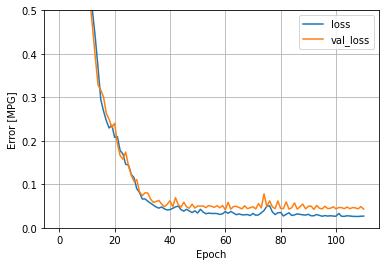

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Evaluate neural network

In [18]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.0429 - mse: 0.0429
loss test data:  0.042922936379909515
mse test data:  0.042922936379909515
4/4 [==============================] - 0s 2ms/step - loss: 0.0274 - mse: 0.0274
loss train data:  0.027389787137508392
mse train data:  0.027389787137508392


Plot results

<function matplotlib.pyplot.show>

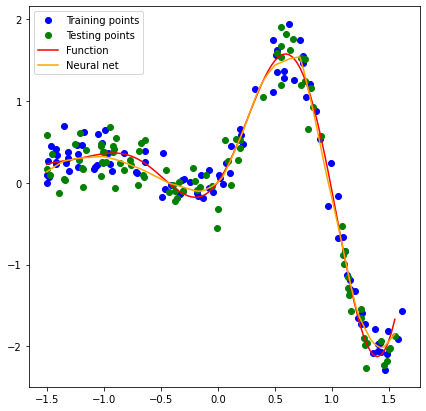

In [19]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-meany)/stdy,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')

#plt.plot(XX_train_n, model0.predict(XX_train_n), 'o',  color='red', label='NN')

plt.legend()


plt.show